In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from preprocessor import get_train_environment
from itertools import product
from sklearn.metrics import confusion_matrix

In [2]:
def interleave(classifier_results, regressor_results):
    output = []
    i = 0
    for res in classifier_results:
        if res == 1:
            output.append(0)
        else:
            output.append(regressor_results[i])
            i += 1
    return output

In [20]:
interleave([0, 1, 1, 0], [5, 6])

[5, 0, 0, 6]

In [24]:
envGen = get_train_environment(n_splits=5)
results = []
n_estimators = [50, 100, 200, 400]
max_depths = [2, 3, 4, 5]
hyperparamSpace = [x for x in product(n_estimators, max_depths)]


# The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
stats, X, X_holdout, y, y_holdout = next(envGen)

featureNums = range(1, len(X[0]), 10)

featureNumMSEs = {}

mses = {}

# Cross validation folds
for fold, stats, X_train_fold, X_test_fold, y_train_fold, y_test_fold in envGen:
    print(f"Fold: {fold}")
    
    class_y_train = y_train_fold < 0.5
    class_y_test = y_test_fold < 0.5

    classifier = XGBClassifier(n_estimators=80, max_depth=4)
    classifier.fit(X_train_fold, class_y_train)
    
    class_train_predict = classifier.predict(X_train_fold)
    class_test_predict = classifier.predict(X_test_fold)
#     print(len(class_test_predict))
    # print(confusion_matrix(class_y_train, class_train_predict))
    
    to_train_final_X = X_train_fold[class_train_predict != 1]
    to_train_final_Y = y_train_fold[class_train_predict != 1]
    
    to_test_final_X = X_test_fold[class_test_predict != 1]
    
    for (n, d) in hyperparamSpace:
        print("Hypyerparams: ", n, d)
        model = XGBRegressor(n_estimators=n, max_depth=d)
        model.fit(to_train_final_X, to_train_final_Y)
        
        test_preds = model.predict(to_test_final_X)
        actual_test_preds = interleave(class_test_predict, test_preds)
        
        mse = mean_squared_error(y_test_fold, actual_test_preds)
        if (n, d) in mses:
            mses[(n, d)].append(mse)
        else:
            mses[(n, d)] = [mse]
    
#     thresholds = enumerate(model.feature_importances_)
#     thresholds = [x for x in thresholds]
#     thresholds.sort(key=lambda x: x[1], reverse=True)
    
    
#     eps = 0.000001
#     lastMSE = None
#     for featureNum in featureNums:
#         selectedFeatures = [i for i, x in thresholds[:featureNum]]
        
#         model = XGBRegressor(n_estimators=300, max_depth=4)
#         XT = X_train_fold[:, selectedFeatures]
#         model.fit(XT, y_train_fold)
        
#         predictions = model.predict(X_test_fold[:, selectedFeatures])
#         mse = mean_squared_error(y_test_fold, predictions)
        
#         if lastMSE is not None:
#             if np.abs(mse - lastMSE) < eps:
#                 break
#             else:
#                 lastMSE = mse
#         else:
#             lastMSE = mse
        
#         if featureNum in featureNumMSEs:
#             featureNumMSEs[featureNum].append(mse)
#         else:
#             featureNumMSEs[featureNum] = [mse]
        
#         print(f"FeatureNum: {featureNum}")
#         print("FeatureNum Mean Squared Error: ", mse)



Found cached folds, using those
Fold: 0
1893
Hypyerparams:  50 2
Hypyerparams:  50 3
Hypyerparams:  50 4
Hypyerparams:  50 5
Hypyerparams:  100 2
Hypyerparams:  100 3
Hypyerparams:  100 4
Hypyerparams:  100 5
Hypyerparams:  200 2
Hypyerparams:  200 3
Hypyerparams:  200 4
Hypyerparams:  200 5
Hypyerparams:  400 2
Hypyerparams:  400 3
Hypyerparams:  400 4
Hypyerparams:  400 5
Fold: 1
1893
Hypyerparams:  50 2
Hypyerparams:  50 3
Hypyerparams:  50 4
Hypyerparams:  50 5
Hypyerparams:  100 2
Hypyerparams:  100 3
Hypyerparams:  100 4
Hypyerparams:  100 5
Hypyerparams:  200 2
Hypyerparams:  200 3
Hypyerparams:  200 4
Hypyerparams:  200 5
Hypyerparams:  400 2
Hypyerparams:  400 3
Hypyerparams:  400 4
Hypyerparams:  400 5
Fold: 2
1892
Hypyerparams:  50 2
Hypyerparams:  50 3
Hypyerparams:  50 4
Hypyerparams:  50 5
Hypyerparams:  100 2
Hypyerparams:  100 3
Hypyerparams:  100 4
Hypyerparams:  100 5
Hypyerparams:  200 2
Hypyerparams:  200 3
Hypyerparams:  200 4
Hypyerparams:  200 5
Hypyerparams:  40

In [26]:
new_mses = {x: np.mean(mses[x]) for x in mses}

In [28]:
plot_df = pd.DataFrame.from_dict([{"n_est": k[0], "depth": k[1], "mse": v} for k, v in new_mses.items()])

<Axes: xlabel='n_est', ylabel='mse'>

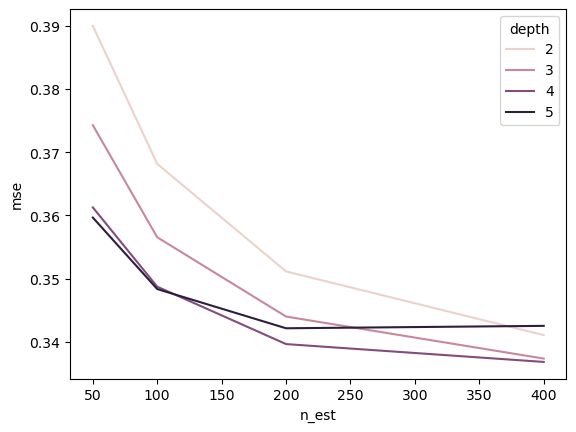

In [31]:
sns.lineplot(data=plot_df, x="n_est", y="mse", hue="depth")

In [32]:
envGen = get_train_environment(n_splits=5)
results = []
n_estimators = [200, 300, 400]
max_depths = [3, 4]
hyperparamSpace = [x for x in product(n_estimators, max_depths)]


# The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
stats, X, X_holdout, y, y_holdout = next(envGen)

featureNums = range(10, len(X[0]), 20)

featureNumMSEs = {}

# Cross validation folds
for fold, stats, X_train_fold, X_test_fold, y_train_fold, y_test_fold in envGen:
    print(f"Fold: {fold}")
    
    class_y_train = y_train_fold < 0.5
    class_y_test = y_test_fold < 0.5

    classifier = XGBClassifier(n_estimators=80, max_depth=4)
    classifier.fit(X_train_fold, class_y_train)
    
    class_train_predict = classifier.predict(X_train_fold)
    class_test_predict = classifier.predict(X_test_fold)
    
    to_train_final_X = X_train_fold[class_train_predict != 1]
    to_train_final_Y = y_train_fold[class_train_predict != 1]
    
    to_test_final_X = X_test_fold[class_test_predict != 1]
    
    selector = XGBRegressor(n_estimators=200, max_depth=4)
    selector.fit(to_train_final_X, to_train_final_Y)
    
    
    thresholds = enumerate(selector.feature_importances_)
    thresholds = [x for x in thresholds]
    thresholds.sort(key=lambda x: x[1], reverse=True)
    
    
    eps = 0.000001
    lastMSE = None
    
    for (n, d) in hyperparamSpace:
        for featureNum in featureNums:
            print("Hypyerparams: ", n, d, featureNum)
            selectedFeatures = [i for i, x in thresholds[:featureNum]]
            
            model = XGBRegressor(n_estimators=n, max_depth=d)
            XT = to_train_final_X[:, selectedFeatures]
            model.fit(XT, to_train_final_Y)
            
            predictions = model.predict(to_test_final_X[:, selectedFeatures])
            
            actual_test_preds = interleave(class_test_predict, predictions)

            mse = mean_squared_error(y_test_fold, actual_test_preds)
            if (featureNum, n, d) in featureNumMSEs:
                featureNumMSEs[(featureNum, n, d)].append(mse)
            else:
                featureNumMSEs[(featureNum, n, d)] = [mse]
                

            if lastMSE is not None:
                if np.abs(mse - lastMSE) < eps:
                    break
                else:
                    lastMSE = mse
            else:
                lastMSE = mse

Found cached folds, using those
Fold: 0
Hypyerparams:  200 3 10
Hypyerparams:  200 3 30
Hypyerparams:  200 3 50
Hypyerparams:  200 3 70
Hypyerparams:  200 3 90
Hypyerparams:  200 3 110
Hypyerparams:  200 3 130
Hypyerparams:  200 3 150
Hypyerparams:  200 3 170
Hypyerparams:  200 3 190
Hypyerparams:  200 3 210
Hypyerparams:  200 3 230
Hypyerparams:  200 3 250
Hypyerparams:  200 3 270
Hypyerparams:  200 3 290
Hypyerparams:  200 3 310
Hypyerparams:  200 3 330
Hypyerparams:  200 3 350
Hypyerparams:  200 3 370
Hypyerparams:  200 3 390
Hypyerparams:  200 3 410
Hypyerparams:  200 3 430
Hypyerparams:  200 3 450
Hypyerparams:  200 3 470
Hypyerparams:  200 3 490
Hypyerparams:  200 4 10
Hypyerparams:  200 4 30
Hypyerparams:  200 4 50
Hypyerparams:  200 4 70
Hypyerparams:  200 4 90
Hypyerparams:  200 4 110
Hypyerparams:  200 4 130
Hypyerparams:  200 4 150
Hypyerparams:  200 4 170
Hypyerparams:  200 4 190
Hypyerparams:  200 4 210
Hypyerparams:  200 4 230
Hypyerparams:  200 4 250
Hypyerparams:  200 4

Hypyerparams:  300 4 110
Hypyerparams:  300 4 130
Hypyerparams:  300 4 150
Hypyerparams:  300 4 170
Hypyerparams:  300 4 190
Hypyerparams:  300 4 210
Hypyerparams:  300 4 230
Hypyerparams:  300 4 250
Hypyerparams:  300 4 270
Hypyerparams:  300 4 290
Hypyerparams:  300 4 310
Hypyerparams:  300 4 330
Hypyerparams:  300 4 350
Hypyerparams:  300 4 370
Hypyerparams:  300 4 390
Hypyerparams:  300 4 410
Hypyerparams:  300 4 430
Hypyerparams:  300 4 450
Hypyerparams:  300 4 470
Hypyerparams:  300 4 490
Hypyerparams:  300 4 510
Hypyerparams:  300 4 530
Hypyerparams:  300 4 550
Hypyerparams:  300 4 570
Hypyerparams:  300 4 590
Hypyerparams:  300 4 610
Hypyerparams:  300 4 630
Hypyerparams:  300 4 650
Hypyerparams:  300 4 670
Hypyerparams:  300 4 690
Hypyerparams:  300 4 710
Hypyerparams:  300 4 730
Hypyerparams:  300 4 750
Hypyerparams:  300 4 770
Hypyerparams:  300 4 790
Hypyerparams:  300 4 810
Hypyerparams:  300 4 830
Hypyerparams:  300 4 850
Hypyerparams:  300 4 870
Hypyerparams:  300 4 890


Hypyerparams:  400 3 690
Hypyerparams:  400 3 710
Hypyerparams:  400 3 730
Hypyerparams:  400 3 750
Hypyerparams:  400 3 770
Hypyerparams:  400 3 790
Hypyerparams:  400 3 810
Hypyerparams:  400 3 830
Hypyerparams:  400 3 850
Hypyerparams:  400 3 870
Hypyerparams:  400 3 890
Hypyerparams:  400 4 10
Hypyerparams:  400 4 30
Hypyerparams:  400 4 50
Hypyerparams:  400 4 70
Hypyerparams:  400 4 90
Hypyerparams:  400 4 110
Hypyerparams:  400 4 130
Hypyerparams:  400 4 150
Hypyerparams:  400 4 170
Hypyerparams:  400 4 190
Hypyerparams:  400 4 210
Hypyerparams:  400 4 230
Hypyerparams:  400 4 250
Hypyerparams:  400 4 270
Hypyerparams:  400 4 290
Hypyerparams:  400 4 310
Hypyerparams:  400 4 330
Hypyerparams:  400 4 350
Hypyerparams:  400 4 370
Hypyerparams:  400 4 390
Hypyerparams:  400 4 410
Hypyerparams:  400 4 430
Hypyerparams:  400 4 450
Hypyerparams:  400 4 470
Hypyerparams:  400 4 490
Hypyerparams:  400 4 510
Hypyerparams:  400 4 530
Hypyerparams:  400 4 550
Hypyerparams:  400 4 570
Hypye

Hypyerparams:  400 4 1130
Hypyerparams:  400 4 1150
Hypyerparams:  400 4 1170
Hypyerparams:  400 4 1190
Fold: 4
Hypyerparams:  200 3 10
Hypyerparams:  200 3 30
Hypyerparams:  200 3 50
Hypyerparams:  200 3 70
Hypyerparams:  200 3 90
Hypyerparams:  200 3 110
Hypyerparams:  200 3 130
Hypyerparams:  200 3 150
Hypyerparams:  200 3 170
Hypyerparams:  200 3 190
Hypyerparams:  200 3 210
Hypyerparams:  200 3 230
Hypyerparams:  200 3 250
Hypyerparams:  200 3 270
Hypyerparams:  200 3 290
Hypyerparams:  200 3 310
Hypyerparams:  200 3 330
Hypyerparams:  200 3 350
Hypyerparams:  200 3 370
Hypyerparams:  200 3 390
Hypyerparams:  200 3 410
Hypyerparams:  200 3 430
Hypyerparams:  200 3 450
Hypyerparams:  200 3 470
Hypyerparams:  200 3 490
Hypyerparams:  200 3 510
Hypyerparams:  200 4 10
Hypyerparams:  200 4 30
Hypyerparams:  200 4 50
Hypyerparams:  200 4 70
Hypyerparams:  200 4 90
Hypyerparams:  200 4 110
Hypyerparams:  200 4 130
Hypyerparams:  200 4 150
Hypyerparams:  200 4 170
Hypyerparams:  200 4 19

In [36]:
featureNumMSEs = {k: v for k, v in mses.items() if len(k) > 2}

In [38]:
fdf_plot = [{"fnum": k[0], "n_est": k[1], "max_depth": k[2], "mse": v[0]} for k, v in featureNumMSEs.items()]

In [40]:
fdf_plot = pd.DataFrame.from_dict(fdf_plot)

In [41]:
fdf_plot

,fnum,n_est,max_depth,mse
0,10,200,3,0.500758
1,30,200,3,0.433398
2,50,200,3,0.435932
3,70,200,3,0.450532
4,90,200,3,0.374039
...,...,...,...,...
289,1130,300,4,0.345862
290,1150,300,4,0.343049
291,1170,300,4,0.342683
292,1190,300,4,0.343750


<Axes: xlabel='fnum', ylabel='mse'>

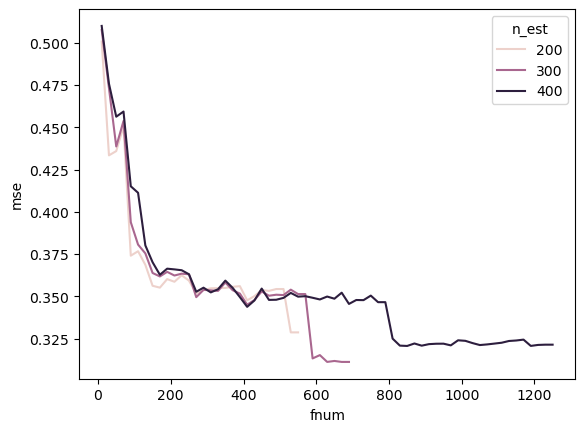

In [43]:
sns.lineplot(x="fnum", y="mse", hue="n_est", data=fdf_plot[fdf_plot["max_depth"] == 3])

<Axes: xlabel='fnum', ylabel='mse'>

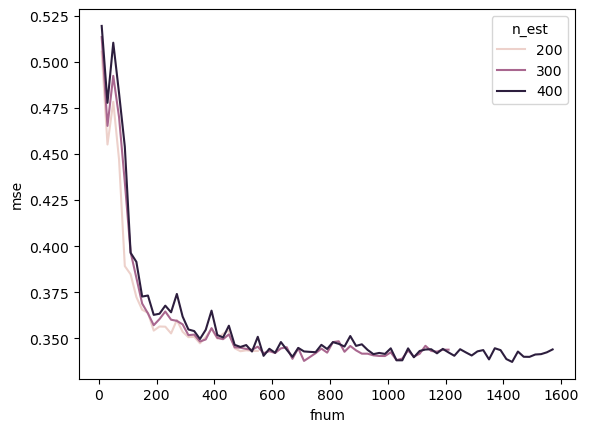

In [44]:
sns.lineplot(x="fnum", y="mse", hue="n_est", data=fdf_plot[fdf_plot["max_depth"] == 4])

In [135]:
envGen = get_train_environment(n_splits=5)
results = []
# n_estimators = [100, 200, 300, 400]
n_estimators = [3200]
max_depths = [1]
hyperparamSpace = [x for x in product(n_estimators, max_depths)]


# The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
stats, X, X_holdout, y, y_holdout = next(envGen)

#featureNums = range(10, len(X[0]), 20)
featureNums = range(100, len(X[0]) - 600, 100)

# featureNumMSEs2 = {}

# Cross validation folds
for fold, stats, X_train_fold, X_test_fold, y_train_fold, y_test_fold in envGen:
    print(f"Fold: {fold}")
    
    class_y_train = y_train_fold < 0.5
    class_y_test = y_test_fold < 0.5

    classifier = XGBClassifier(n_estimators=80, max_depth=4)
    classifier.fit(X_train_fold, class_y_train)
    
    class_train_predict = classifier.predict(X_train_fold)
    class_test_predict = classifier.predict(X_test_fold)
    
    to_train_final_X = X_train_fold[class_train_predict != 1]
    to_train_final_Y = y_train_fold[class_train_predict != 1]
    
    to_test_final_X = X_test_fold[class_test_predict != 1]
    
    selector = XGBRegressor(n_estimators=200, max_depth=4)
    selector.fit(to_train_final_X, to_train_final_Y)
    
    
    thresholds = enumerate(selector.feature_importances_)
    thresholds = [x for x in thresholds]
    thresholds.sort(key=lambda x: x[1], reverse=True)
    
    
    eps = 0.000001
    secondLastMSE = None
    lastMSE = None
    
    for (n, d) in hyperparamSpace:
        for featureNum in featureNums:
            print("Hypyerparams: ", n, d, featureNum)
            selectedFeatures = [i for i, x in thresholds[:featureNum]]
            
            model = XGBRegressor(n_estimators=n, max_depth=d)
            XT = to_train_final_X[:, selectedFeatures]
            model.fit(XT, to_train_final_Y)
            
            predictions = model.predict(to_test_final_X[:, selectedFeatures])
            
            actual_test_preds = interleave(class_test_predict, predictions)

            mse = mean_squared_error(y_test_fold, actual_test_preds)
            if (featureNum, n, d) in featureNumMSEs2:
                featureNumMSEs2[(featureNum, n, d)].append(mse)
            else:
                featureNumMSEs2[(featureNum, n, d)] = [mse]
                
            if secondLastMSE is not None:
                if (np.abs(mse - lastMSE) < eps) and (np.abs(lastMSE - secondLastMSE) < eps):
                    break
                else:
                    secondLastMSE = lastMSE
                    lastMSE = mse
            else:
                secondLastMSE = lastMSE
                lastMSE = mse

Found cached folds, using those
Fold: 0
Hypyerparams:  3200 1 100
Hypyerparams:  3200 1 200
Hypyerparams:  3200 1 300
Hypyerparams:  3200 1 400
Hypyerparams:  3200 1 500
Hypyerparams:  3200 1 600
Hypyerparams:  3200 1 700
Hypyerparams:  3200 1 800
Hypyerparams:  3200 1 900
Fold: 1
Hypyerparams:  3200 1 100
Hypyerparams:  3200 1 200
Hypyerparams:  3200 1 300
Hypyerparams:  3200 1 400
Hypyerparams:  3200 1 500
Hypyerparams:  3200 1 600
Hypyerparams:  3200 1 700
Hypyerparams:  3200 1 800
Hypyerparams:  3200 1 900
Fold: 2
Hypyerparams:  3200 1 100
Hypyerparams:  3200 1 200
Hypyerparams:  3200 1 300
Hypyerparams:  3200 1 400
Hypyerparams:  3200 1 500
Hypyerparams:  3200 1 600
Hypyerparams:  3200 1 700
Hypyerparams:  3200 1 800
Hypyerparams:  3200 1 900
Fold: 3
Hypyerparams:  3200 1 100
Hypyerparams:  3200 1 200
Hypyerparams:  3200 1 300
Hypyerparams:  3200 1 400
Hypyerparams:  3200 1 500
Hypyerparams:  3200 1 600
Hypyerparams:  3200 1 700
Hypyerparams:  3200 1 800
Hypyerparams:  3200 1 900


In [91]:
featureNumMSEs2

{(10, 100, 1): [0.5006632272077471,
  0.5099449047834558,
  0.4635307558332664,
  0.46323775965673075,
  0.4954856436584893],
 (30, 100, 1): [0.4292544880300473,
  0.44775092087369733,
  0.4035337896824038,
  0.4087750153763568,
  0.4293149983726116],
 (50, 100, 1): [0.42413917978317156,
  0.44238723161947147,
  0.3888676267154179,
  0.4009746861804791,
  0.41817287589158886],
 (70, 100, 1): [0.42480621765056237,
  0.44004300643809724,
  0.38613007536647587,
  0.4013348143309557,
  0.4169436561858947],
 (90, 100, 1): [0.4217067467485947,
  0.4388669467042487,
  0.38727080145827647,
  0.39848927396007056,
  0.41133513050285975],
 (110, 100, 1): [0.4199490337493075,
  0.4370748464855825,
  0.3764232166166358,
  0.39201575599926874,
  0.41163359914365216],
 (130, 100, 1): [0.4118220795593147,
  0.4370748464855825,
  0.3764232166166358,
  0.39201575599926874,
  0.4102608276843979],
 (150, 100, 1): [0.41027733964533564,
  0.4327187410537747,
  0.3764232166166358,
  0.39186098827962024,
  0.

In [141]:
featureNumMSEs2a = {x: y for x, y in featureNumMSEs2.items() if len(y) >= 4}

In [142]:
plotme = [{"fnum": k[0], "n_est": k[1], "max_depth": k[2], "mse": np.mean(v)} for k, v in featureNumMSEs2a.items() if (k[0] < 1000) and (k[0] > 50)]

In [143]:
plotme = pd.DataFrame.from_dict(plotme)

In [144]:
plotme

,fnum,n_est,max_depth,mse
0,70,100,1,0.413852
1,90,100,1,0.411534
2,110,100,1,0.407419
3,130,100,1,0.405519
4,150,100,1,0.403079
...,...,...,...,...
351,500,3200,1,0.345025
352,600,3200,1,0.343355
353,700,3200,1,0.342475
354,800,3200,1,0.341934


<Axes: xlabel='fnum', ylabel='mse'>

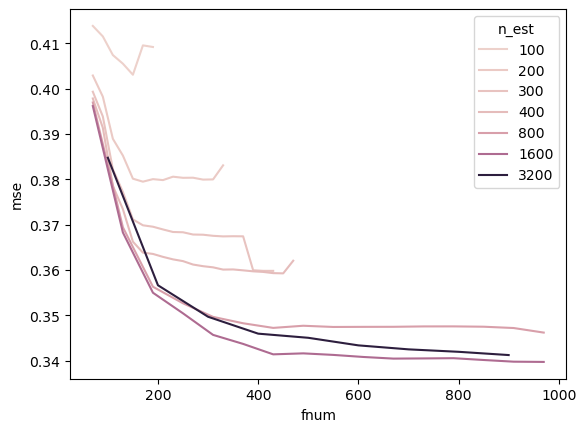

In [150]:
sns.lineplot(data=plotme[plotme["max_depth"] == 1], x="fnum", y="mse", hue="n_est", legend='full')

<Axes: xlabel='fnum', ylabel='mse'>

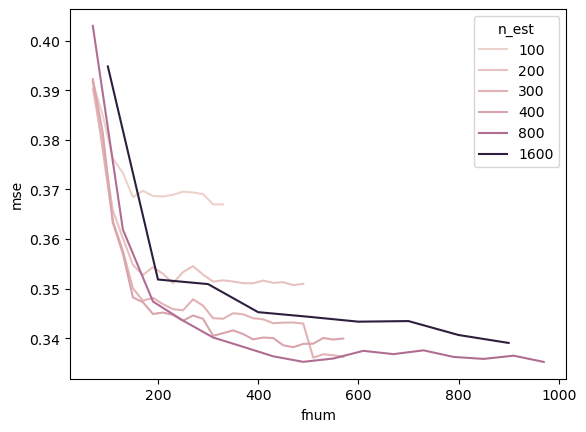

In [146]:
sns.lineplot(data=plotme[plotme["max_depth"] == 2], x="fnum", y="mse", hue="n_est")

<Axes: xlabel='fnum', ylabel='mse'>

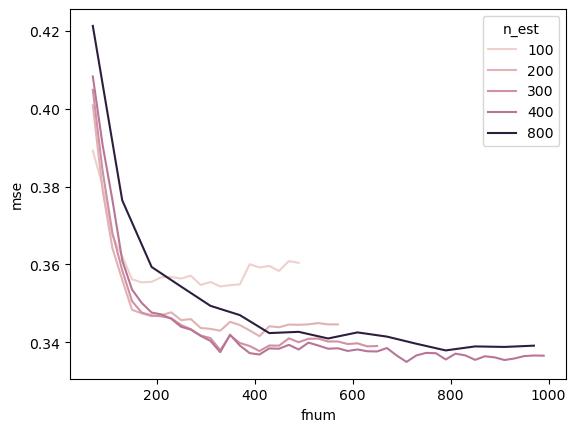

In [147]:
sns.lineplot(data=plotme[plotme["max_depth"] == 3], x="fnum", y="mse", hue="n_est")

In [148]:
min(plotme["mse"])

0.33501539534328445

In [162]:
plotme[plotme["mse"] <= 0.337]

,fnum,n_est,max_depth,mse
144,510,300,2,0.336056
145,530,300,2,0.336751
146,550,300,2,0.336551
147,570,300,2,0.336238
244,410,400,3,0.336912
258,690,400,3,0.336662
259,710,400,3,0.335015
260,730,400,3,0.336668
263,790,400,3,0.335637
265,830,400,3,0.336694


In [167]:
def cand(x, y, z):
    return (x, y, z)
#     return {"fnum": x, "n_est": y, "max_depth": z}

In [168]:
candidates = [cand(530, 300, 2), cand(410, 400, 3), cand(720, 400, 3), cand(450, 800, 2), cand(850, 800, 2)]

In [170]:
envGen = get_train_environment(n_splits=50)
results = []

# The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
stats, X, X_holdout, y, y_holdout = next(envGen)

#featureNums = range(10, len(X[0]), 20)
# featureNums = range(100, len(X[0]) - 600, 100)

# featureNumMSEs2 = {}

candMSEs = {}

# Cross validation folds
for fold, stats, X_train_fold, X_test_fold, y_train_fold, y_test_fold in envGen:
    print(f"Fold: {fold}")
    
    class_y_train = y_train_fold < 0.5
    class_y_test = y_test_fold < 0.5

    classifier = XGBClassifier(n_estimators=80, max_depth=4)
    classifier.fit(X_train_fold, class_y_train)
    
    class_train_predict = classifier.predict(X_train_fold)
    class_test_predict = classifier.predict(X_test_fold)
    
    to_train_final_X = X_train_fold[class_train_predict != 1]
    to_train_final_Y = y_train_fold[class_train_predict != 1]
    
    to_test_final_X = X_test_fold[class_test_predict != 1]
    
    selector = XGBRegressor(n_estimators=200, max_depth=4)
    selector.fit(to_train_final_X, to_train_final_Y)
    
    
    thresholds = enumerate(selector.feature_importances_)
    thresholds = [x for x in thresholds]
    thresholds.sort(key=lambda x: x[1], reverse=True)
    
    
    eps = 0.000001
    secondLastMSE = None
    lastMSE = None
    
    for (featureNum, n, d) in candidates:
        print("Hypyerparams: ", n, d, featureNum)
        selectedFeatures = [i for i, x in thresholds[:featureNum]]

        model = XGBRegressor(n_estimators=n, max_depth=d)
        XT = to_train_final_X[:, selectedFeatures]
        model.fit(XT, to_train_final_Y)

        predictions = model.predict(to_test_final_X[:, selectedFeatures])

        actual_test_preds = interleave(class_test_predict, predictions)

        mse = mean_squared_error(y_test_fold, actual_test_preds)
        if (featureNum, n, d) in candMSEs:
            candMSEs[(featureNum, n, d)].append(mse)
        else:
            candMSEs[(featureNum, n, d)] = [mse]

No cached folds found, generating new folds.
Fold: 0
Hypyerparams:  300 2 530
Hypyerparams:  400 3 410
Hypyerparams:  400 3 720
Hypyerparams:  800 2 450
Hypyerparams:  800 2 850
Fold: 1
Hypyerparams:  300 2 530
Hypyerparams:  400 3 410
Hypyerparams:  400 3 720
Hypyerparams:  800 2 450
Hypyerparams:  800 2 850
Fold: 2
Hypyerparams:  300 2 530
Hypyerparams:  400 3 410
Hypyerparams:  400 3 720
Hypyerparams:  800 2 450
Hypyerparams:  800 2 850
Fold: 3
Hypyerparams:  300 2 530
Hypyerparams:  400 3 410
Hypyerparams:  400 3 720
Hypyerparams:  800 2 450
Hypyerparams:  800 2 850
Fold: 4
Hypyerparams:  300 2 530
Hypyerparams:  400 3 410
Hypyerparams:  400 3 720
Hypyerparams:  800 2 450
Hypyerparams:  800 2 850
Fold: 5
Hypyerparams:  300 2 530
Hypyerparams:  400 3 410
Hypyerparams:  400 3 720
Hypyerparams:  800 2 450
Hypyerparams:  800 2 850
Fold: 6
Hypyerparams:  300 2 530
Hypyerparams:  400 3 410
Hypyerparams:  400 3 720
Hypyerparams:  800 2 450
Hypyerparams:  800 2 850
Fold: 7
Hypyerparams:  3

In [3]:
from json import dump, load

In [155]:
featureNumMSEs2d = {str(x): y for x, y in featureNumMSEs2.items()}

In [157]:
with open("featNumDump.json", 'w') as file:
    dump(featureNumMSEs2d, file)

In [183]:
with open("candNumDump.json", 'w') as file:
    dump(candMSEs2, file)

In [4]:
with open("featNumDump.json", 'r') as file:
    featureNumMSEs2d = load(file)

In [5]:
with open("candNumDump.json", 'r') as file:
    candMSEs2 = load(file)

In [11]:
candMSEs3 = [[{"hps": x["hps"], "mse": mse} for mse in x["mse"]] for x in candMSEs2]

In [21]:
candMSEstoDF = []
for x in candMSEs3:
    candMSEstoDF += x

In [58]:
candMSEs4 = pd.DataFrame.from_dict(candMSEstoDF)

<Axes: xlabel='mse', ylabel='hps'>

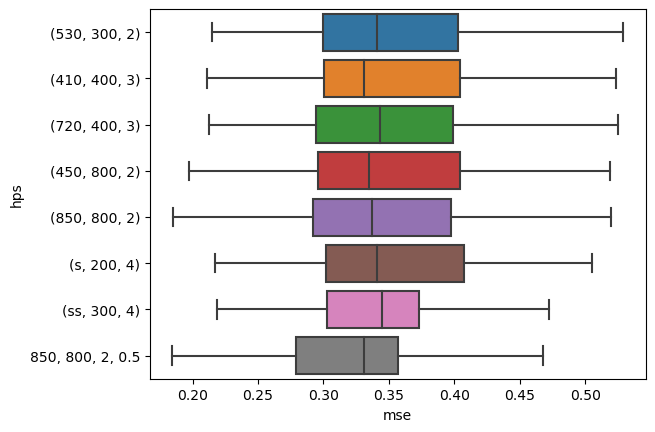

In [59]:
sns.boxplot(x="mse", data=candMSEs4, y="hps")

In [61]:
finalLogModels = [x for x in candMSEstoDF if x["hps"] not in ("(530, 300, 2)", "(410, 400, 3)", "(720, 400, 3)", "(450, 800, 2)")]

In [65]:
def fixDicts(x):
    if x["hps"] == "(850, 800, 2)":
        return {"method": "Classifier -> Top 850 Feature XGB", **x}
    if x["hps"] == "(s, 200, 4)":
        return {"method": "Classifier -> XGB", **x}
    if x["hps"] == "(ss, 300, 4)":
        return {"method": "XGB", **x}
    if x["hps"] == "850, 800, 2, 0.5":
        return {"method": "XGB, Classifier -> Top 850 XGB mix", **x}

In [66]:
finalLogModels = [fixDicts(x) for x in finalLogModels]

In [69]:
FinalLogToPlot = pd.DataFrame.from_dict(finalLogModels)

In [80]:
def getKey(x):
    print(x)
    if x["method"] == "XGB":
        return 0
    elif x["method"] == "Classifier -> XGB":
        return 1
    elif x["method"] == "Classifier -> Top 850 Feature XGB":
        return 2
    elif x["method"] == "XGB, Classifier -> Top 850 XGB mix":
        return 3

In [83]:
FinalLogToPlot["sort_index"] = FinalLogToPlot.apply(getKey, axis=1)

method    Classifier -> Top 850 Feature XGB
hps                           (850, 800, 2)
mse                                0.314296
Name: 0, dtype: object
method    Classifier -> Top 850 Feature XGB
hps                           (850, 800, 2)
mse                                0.424566
Name: 1, dtype: object
method    Classifier -> Top 850 Feature XGB
hps                           (850, 800, 2)
mse                                0.468611
Name: 2, dtype: object
method    Classifier -> Top 850 Feature XGB
hps                           (850, 800, 2)
mse                                 0.31426
Name: 3, dtype: object
method    Classifier -> Top 850 Feature XGB
hps                           (850, 800, 2)
mse                                0.310016
Name: 4, dtype: object
method    Classifier -> Top 850 Feature XGB
hps                           (850, 800, 2)
mse                                0.329666
Name: 5, dtype: object
method    Classifier -> Top 850 Feature XGB
hps                       

In [85]:
FinalLogToPlot.sort_values("sort_index")

,method,hps,mse,sort_index
101,XGB,"(ss, 300, 4)",0.472483,0
123,XGB,"(ss, 300, 4)",0.345913,0
122,XGB,"(ss, 300, 4)",0.408894,0
121,XGB,"(ss, 300, 4)",0.239102,0
120,XGB,"(ss, 300, 4)",0.308603,0
...,...,...,...,...
169,"XGB, Classifier -> Top 850 XGB mix","850, 800, 2, 0.5",0.204253,3
170,"XGB, Classifier -> Top 850 XGB mix","850, 800, 2, 0.5",0.287882,3
171,"XGB, Classifier -> Top 850 XGB mix","850, 800, 2, 0.5",0.209269,3
161,"XGB, Classifier -> Top 850 XGB mix","850, 800, 2, 0.5",0.410881,3


Text(0.5, 1.0, 'Results on Log Transformed Prices')

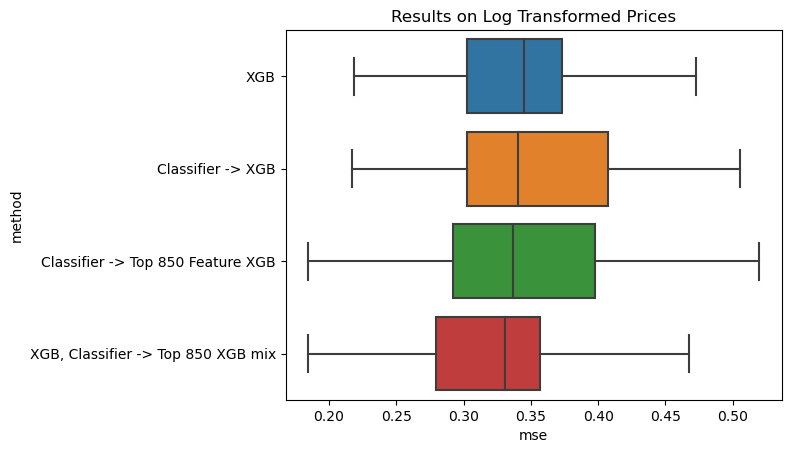

In [90]:
sns.boxplot(x="mse", data=FinalLogToPlot.sort_values("sort_index"), y="method").set_title("Results on Log Transformed Prices")

In [39]:
envGen = get_train_environment(n_splits=50)
results = []
n_estimators = [300]
max_depths = [4]
hyperparamSpace = [x for x in product(n_estimators, max_depths)]


# The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
stats, X, X_holdout, y, y_holdout = next(envGen)


simpleMSEs = []

# Cross validation folds
for fold, stats, X_train_fold, X_test_fold, y_train_fold, y_test_fold in envGen:
    print(f"Fold: {fold}")
    for (n, d) in hyperparamSpace:
        print("Hypyerparams: ", n, d)
        model = XGBRegressor(n_estimators=n, max_depth=d)
        model.fit(X_train_fold, y_train_fold)
        
        test_preds = model.predict(X_test_fold)
#         actual_test_preds = interleave(class_test_predict, test_preds)
        
        mse = mean_squared_error(y_test_fold, test_preds)
        simpleMSEs.append(mse)

Found cached folds, using those
Fold: 0
Hypyerparams:  300 4
Fold: 1
Hypyerparams:  300 4
Fold: 2
Hypyerparams:  300 4
Fold: 3
Hypyerparams:  300 4
Fold: 4
Hypyerparams:  300 4
Fold: 5
Hypyerparams:  300 4
Fold: 6
Hypyerparams:  300 4
Fold: 7
Hypyerparams:  300 4
Fold: 8
Hypyerparams:  300 4
Fold: 9
Hypyerparams:  300 4
Fold: 10
Hypyerparams:  300 4
Fold: 11
Hypyerparams:  300 4
Fold: 12
Hypyerparams:  300 4
Fold: 13
Hypyerparams:  300 4
Fold: 14
Hypyerparams:  300 4
Fold: 15
Hypyerparams:  300 4
Fold: 16
Hypyerparams:  300 4
Fold: 17
Hypyerparams:  300 4
Fold: 18
Hypyerparams:  300 4
Fold: 19
Hypyerparams:  300 4
Fold: 20
Hypyerparams:  300 4
Fold: 21
Hypyerparams:  300 4
Fold: 22
Hypyerparams:  300 4
Fold: 23
Hypyerparams:  300 4
Fold: 24
Hypyerparams:  300 4
Fold: 25
Hypyerparams:  300 4
Fold: 26
Hypyerparams:  300 4
Fold: 27
Hypyerparams:  300 4
Fold: 28
Hypyerparams:  300 4
Fold: 29
Hypyerparams:  300 4
Fold: 30
Hypyerparams:  300 4
Fold: 31
Hypyerparams:  300 4
Fold: 32
Hypyerpar

In [40]:
for x in simpleMSEs:
    candMSEstoDF.append({"hps": "(ss, 300, 4)", "mse": x})

In [36]:
candMSEstoDF = [x for x in candMSEstoDF if x["hps"] != "(s, 300, 4)"]

In [56]:
envGen = get_train_environment(n_splits=50)
results = []

# The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
stats, X, X_holdout, y, y_holdout = next(envGen)

#featureNums = range(10, len(X[0]), 20)
# featureNums = range(100, len(X[0]) - 600, 100)
mixamt = 0.5
# featureNumMSEs2 = {}

mixedMSEs = []

# Cross validation folds
for fold, stats, X_train_fold, X_test_fold, y_train_fold, y_test_fold in envGen:
    print(f"Fold: {fold}")
    
    model = XGBRegressor(n_estimators=300, max_depth=4)
    model.fit(X_train_fold, y_train_fold)

    simple_test_preds = model.predict(X_test_fold)

    class_y_train = y_train_fold < 0.5
    class_y_test = y_test_fold < 0.5

    classifier = XGBClassifier(n_estimators=80, max_depth=4)
    classifier.fit(X_train_fold, class_y_train)
    
    class_train_predict = classifier.predict(X_train_fold)
    class_test_predict = classifier.predict(X_test_fold)
    
    to_train_final_X = X_train_fold[class_train_predict != 1]
    to_train_final_Y = y_train_fold[class_train_predict != 1]
    
    to_test_final_X = X_test_fold[class_test_predict != 1]
    
    selector = XGBRegressor(n_estimators=200, max_depth=4)
    selector.fit(to_train_final_X, to_train_final_Y)
    
    
    thresholds = enumerate(selector.feature_importances_)
    thresholds = [x for x in thresholds]
    thresholds.sort(key=lambda x: x[1], reverse=True)
    
    
    eps = 0.000001
    secondLastMSE = None
    lastMSE = None
    
    selectedFeatures = [i for i, x in thresholds[:850]]

    model = XGBRegressor(n_estimators=800, max_depth=2)
    XT = to_train_final_X[:, selectedFeatures]
    model.fit(XT, to_train_final_Y)

    predictions = model.predict(to_test_final_X[:, selectedFeatures])

    actual_test_preds = interleave(class_test_predict, predictions)
    
    fin_preds = mixamt * np.array(actual_test_preds) + (1 - mixamt) * simple_test_preds
    mse = mean_squared_error(y_test_fold, fin_preds)
    mixedMSEs.append({"hps": f"850, 800, 2, {mixamt}", "mse": mse})

Found cached folds, using those
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9
Fold: 10
Fold: 11
Fold: 12
Fold: 13
Fold: 14
Fold: 15
Fold: 16
Fold: 17
Fold: 18
Fold: 19
Fold: 20
Fold: 21
Fold: 22
Fold: 23
Fold: 24
Fold: 25
Fold: 26
Fold: 27
Fold: 28
Fold: 29
Fold: 30
Fold: 31
Fold: 32
Fold: 33
Fold: 34
Fold: 35
Fold: 36
Fold: 37
Fold: 38
Fold: 39
Fold: 40
Fold: 41
Fold: 42
Fold: 43
Fold: 44
Fold: 45
Fold: 46
Fold: 47
Fold: 48
Fold: 49


<Axes: xlabel='mse', ylabel='hps'>

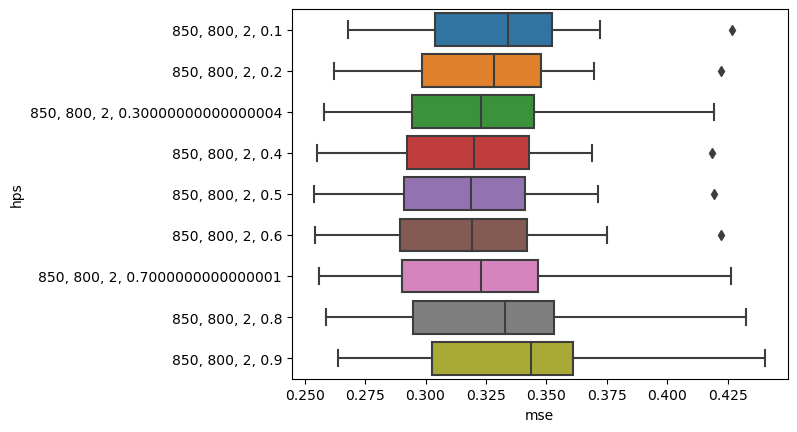

In [46]:
sns.boxplot(x="mse", data=pd.DataFrame.from_dict(mixAMTMSEs), y="hps")

In [57]:
for x in mixedMSEs:
    candMSEstoDF.append(x)

In [53]:
candMSEstoDF = [x for x in candMSEstoDF if x["hps"] != "850, 800, 2, 0.9"]

In [ ]:
envGen = get_train_environment(n_splits=5)
results = []
n_estimators = [100, 200, 400, 800, 1600]
max_depths = [2, 3, 4, 5]
hyperparamSpace = [x for x in product(n_estimators, max_depths)]


# The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
stats, X, X_holdout, y, y_holdout = next(envGen)


nonLogSimpleMSEs = []

# Cross validation folds
for fold, stats, X_train_fold, X_test_fold, y_train_fold, y_test_fold in envGen:
    print(f"Fold: {fold}")
    y_train_fold = np.exp(y_train_fold) - 1

    
    for (n, d) in hyperparamSpace:
        print("Hypyerparams: ", n, d)
        model = XGBRegressor(n_estimators=n, max_depth=d)
        model.fit(X_train_fold, y_train_fold)
        
        test_preds = model.predict(X_test_fold)
#         actual_test_preds = interleave(class_test_predict, test_preds)
        
        mse = mean_squared_error(y_test_fold, test_preds)
        simpleMSEs.append(mse)

In [91]:
stats

{'X_train_median': release_date                 1.545264e+09
 Single-player                1.000000e+00
 Online Co-op                 0.000000e+00
 Shared/Split Screen Co-op    0.000000e+00
 Steam Achievements           1.000000e+00
                                  ...     
 ln.fullAudiop1               6.931472e-01
 ln.interfacep1               1.791759e+00
 ln.subtitlesp1               6.931472e-01
 ln.all-time_peak_ccu         6.269096e+00
 ln.last_30_days_avg_ccu      3.610918e+00
 Length: 1574, dtype: float64,
 'X_train_iqr': release_date                 1.689120e+08
 Single-player                0.000000e+00
 Online Co-op                 0.000000e+00
 Shared/Split Screen Co-op    0.000000e+00
 Steam Achievements           1.000000e+00
                                  ...     
 ln.fullAudiop1               6.931472e-01
 ln.interfacep1               1.704748e+00
 ln.subtitlesp1               2.079442e+00
 ln.all-time_peak_ccu         2.482453e+00
 ln.last_30_days_avg_ccu      2.5

# This is the final model you should use for any graphing/analysis

In [5]:
envGen = get_train_environment(n_splits=5)
stats, X, X_holdout, y, y_holdout = next(envGen)

Found cached folds, using those


In [6]:
fin_model = XGBRegressor(n_estimators=300, max_depth=4)
fin_model.fit(X, y)

simple_test_preds = fin_model.predict(X_holdout)
simple_train_preds = fin_model.predict(X)

class_y_train = y < 0.5
class_y_test = y_holdout < 0.5

classifier = XGBClassifier(n_estimators=80, max_depth=4)
classifier.fit(X, class_y_train)

class_train_predict = classifier.predict(X)
class_test_predict = classifier.predict(X_holdout)

to_train_final_X = X[class_train_predict != 1]
to_train_final_Y = y[class_train_predict != 1]

to_test_final_X = X_holdout[class_test_predict != 1]

selector = XGBRegressor(n_estimators=200, max_depth=4)
selector.fit(to_train_final_X, to_train_final_Y)


thresholds = enumerate(selector.feature_importances_)
thresholds = [x for x in thresholds]
thresholds.sort(key=lambda x: x[1], reverse=True)


selectedFeatures = [i for i, x in thresholds[:850]]

fin_fin_model = XGBRegressor(n_estimators=800, max_depth=2)
XT = to_train_final_X[:, selectedFeatures]
fin_fin_model.fit(XT, to_train_final_Y)

predictions = fin_fin_model.predict(to_test_final_X[:, selectedFeatures])
train_predictions = fin_fin_model.predict(XT)

actual_test_preds = interleave(class_test_predict, predictions)
actual_train_preds = interleave(class_train_predict, train_predictions)

fin_train_preds = 0.5 * np.array(actual_train_preds) + 0.5 * simple_train_preds
fin_holdout_preds = 0.5 * np.array(actual_test_preds) + 0.5 * simple_test_preds
mse = mean_squared_error(y_holdout, fin_holdout_preds)
train_mse = mean_squared_error(y, fin_train_preds)
print("Final train mse: ", train_mse)
print("Final holdout mse: ", mse)

Final train mse:  0.15045490451662838
Final holdout mse:  0.32272247385790254


In [7]:
fin_train_preds = np.clip(fin_train_preds, 0, None)
fin_holdout_preds = np.clip(fin_holdout_preds, 0, None)

In [8]:
simple_train_preds_2 = np.clip(simple_train_preds, 0, None)

In [9]:
mse = mean_squared_error(y_holdout, fin_holdout_preds)
train_mse = mean_squared_error(y, fin_train_preds)
print("Final train mse: ", train_mse)
print("Final holdout mse: ", mse)

Final train mse:  0.1499145133632099
Final holdout mse:  0.3204665403827272


In [10]:
simp_train_mse = mean_squared_error(y, simple_train_preds_2)
simp_ho_mse = mean_squared_error(y_holdout, np.clip(simple_test_preds, 0, None))
print("Simple train mse: ", train_mse)
print("Simple holdout mse: ", simp_ho_mse)

Simple train mse:  0.1499145133632099
Simple holdout mse:  0.32195683618094617


# Make your own graphs for the report as these graphs are purposely bad for better speed of creation

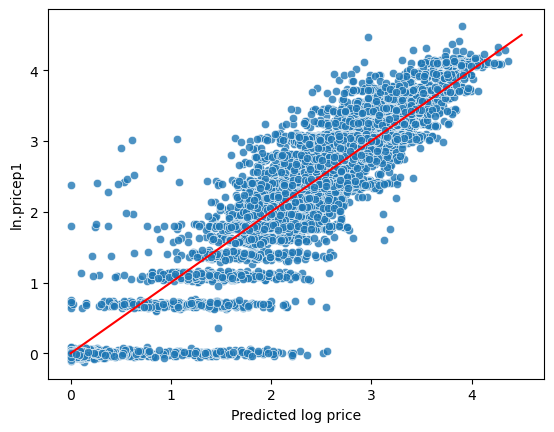

In [139]:
sns.scatterplot(x=fin_train_preds, y=y + np.random.normal(0, 0.03, size=len(y)), alpha=0.8).set_xlabel("Predicted log price")
plt.plot(np.linspace(0, 4.5), np.linspace(0, 4.5), c='r')

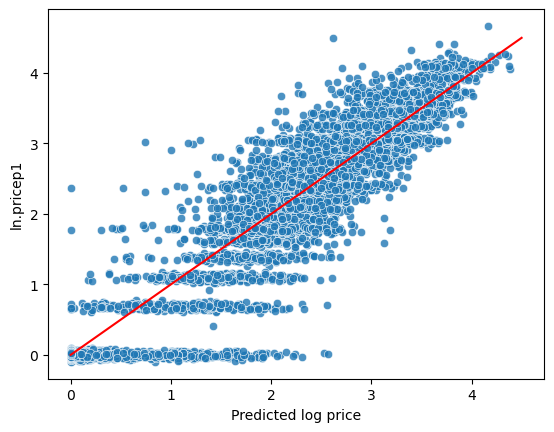

In [138]:
sns.scatterplot(x=simple_train_preds_2, y=y + np.random.normal(0, 0.03, size=len(y)), alpha=0.8).set_xlabel("Predicted log price")
plt.plot(np.linspace(0, 4.5), np.linspace(0, 4.5), c='r')

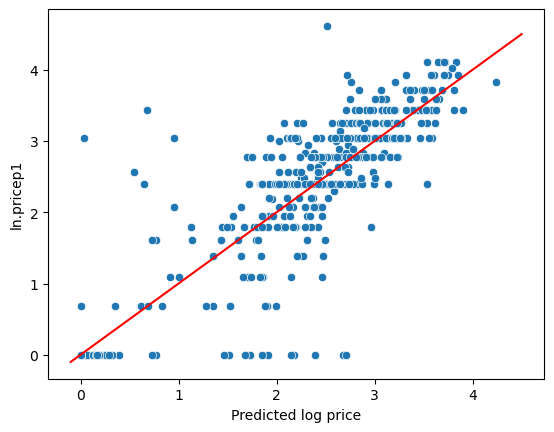

In [124]:
sns.scatterplot(x=fin_holdout_preds, y=y_holdout).set_xlabel("Predicted log price")
plt.plot(np.linspace(-0.1, 4.5), np.linspace(-0.1, 4.5), c='r')

# Example of how to get the feature names back from the final regressor model we use

In [26]:
fin_fin_importances = [(i, x) for i, x in enumerate(fin_fin_model.feature_importances_)]
fin_fin_importances.sort(key=lambda x: x[1], reverse=True)
sim_fin_importances = [(i, x) for i, x in enumerate(fin_model.feature_importances_)]
sim_fin_importances.sort(key=lambda x: x[1], reverse=True)

In [157]:
fin_fin_importances

[(4, 0.028054275),
 (21, 0.024319952),
 (122, 0.021047113),
 (5, 0.020531256),
 (10, 0.019422222),
 (16, 0.016942449),
 (6, 0.016255321),
 (12, 0.016043626),
 (11, 0.01530159),
 (65, 0.013714027),
 (45, 0.013566732),
 (7, 0.013338913),
 (1, 0.011812147),
 (14, 0.0113614695),
 (0, 0.011112554),
 (3, 0.010741916),
 (31, 0.010025016),
 (25, 0.00975349),
 (13, 0.009101334),
 (2, 0.008562524),
 (17, 0.008422945),
 (20, 0.008354046),
 (22, 0.007830648),
 (147, 0.0075559723),
 (8, 0.0073308866),
 (30, 0.0064778295),
 (35, 0.0064518163),
 (170, 0.006007934),
 (100, 0.0059053614),
 (37, 0.0056032804),
 (116, 0.005497813),
 (44, 0.0054387692),
 (64, 0.0053700097),
 (27, 0.0052976934),
 (165, 0.0052856663),
 (23, 0.005239151),
 (33, 0.00516653),
 (28, 0.0051624347),
 (97, 0.0050877724),
 (196, 0.0050715157),
 (47, 0.0050485125),
 (109, 0.00467628),
 (139, 0.004618036),
 (19, 0.004394534),
 (48, 0.0043556797),
 (42, 0.004350618),
 (107, 0.004342349),
 (58, 0.004272035),
 (137, 0.0042487774),
 (56,

In [158]:
selectedFeatures

[29,
 111,
 1566,
 1573,
 30,
 75,
 60,
 68,
 92,
 254,
 1553,
 333,
 45,
 1563,
 1570,
 1222,
 897,
 1564,
 612,
 237,
 1569,
 9,
 893,
 42,
 106,
 157,
 610,
 1386,
 1560,
 259,
 1567,
 14,
 596,
 1571,
 85,
 108,
 719,
 1,
 507,
 69,
 23,
 981,
 59,
 253,
 80,
 214,
 1279,
 124,
 1556,
 379,
 336,
 101,
 261,
 672,
 332,
 263,
 1388,
 52,
 227,
 367,
 143,
 121,
 220,
 288,
 33,
 5,
 816,
 181,
 1537,
 513,
 155,
 933,
 398,
 865,
 1238,
 494,
 89,
 67,
 32,
 1351,
 138,
 1072,
 1338,
 171,
 742,
 233,
 229,
 1339,
 601,
 1572,
 1316,
 1400,
 169,
 1523,
 381,
 471,
 221,
 900,
 48,
 147,
 194,
 449,
 890,
 406,
 62,
 74,
 149,
 25,
 322,
 93,
 1209,
 803,
 574,
 99,
 228,
 1426,
 272,
 875,
 262,
 241,
 619,
 698,
 31,
 1562,
 123,
 365,
 1197,
 47,
 192,
 1000,
 116,
 524,
 402,
 550,
 1365,
 177,
 856,
 217,
 455,
 1439,
 216,
 35,
 244,
 1217,
 931,
 3,
 1561,
 0,
 418,
 115,
 1277,
 36,
 102,
 1073,
 489,
 1285,
 401,
 321,
 626,
 26,
 180,
 323,
 901,
 1398,
 1424,
 15,
 647,


In [160]:
fin_fin_model.feature_importances_

array([0.01111255, 0.01181215, 0.00856252, 0.01074192, 0.02805427,
       0.02053126, 0.01625532, 0.01333891, 0.00733089, 0.00214693,
       0.01942222, 0.01530159, 0.01604363, 0.00910133, 0.01136147,
       0.00105069, 0.01694245, 0.00842294, 0.0026038 , 0.00439453,
       0.00835405, 0.02431995, 0.00783065, 0.00523915, 0.        ,
       0.00975349, 0.00410896, 0.00529769, 0.00516243, 0.        ,
       0.00647783, 0.01002502, 0.        , 0.00516653, 0.00071472,
       0.00645182, 0.00395   , 0.00560328, 0.00063228, 0.00051886,
       0.00147069, 0.        , 0.00435062, 0.00366741, 0.00543877,
       0.01356673, 0.00272468, 0.00504851, 0.00435568, 0.003831  ,
       0.00171824, 0.00159035, 0.        , 0.00037453, 0.00312574,
       0.00146517, 0.00415376, 0.00044046, 0.00427203, 0.00307047,
       0.00331143, 0.        , 0.00085509, 0.        , 0.00537001,
       0.01371403, 0.00250135, 0.00208914, 0.00348526, 0.00190945,
       0.00293999, 0.00258949, 0.00414653, 0.00126476, 0.     

In [161]:
thresholds

[(29, 0.03271797),
 (111, 0.029643092),
 (1566, 0.025074465),
 (1573, 0.02302527),
 (30, 0.016319104),
 (75, 0.01603),
 (60, 0.014844789),
 (68, 0.013824735),
 (92, 0.013660647),
 (254, 0.012274349),
 (1553, 0.011512331),
 (333, 0.0114672305),
 (45, 0.010871701),
 (1563, 0.010596557),
 (1570, 0.0096624065),
 (1222, 0.009636621),
 (897, 0.009443071),
 (1564, 0.008499454),
 (612, 0.008136336),
 (237, 0.007815835),
 (1569, 0.007811425),
 (9, 0.0077677355),
 (893, 0.0068383957),
 (42, 0.0067478153),
 (106, 0.0067404895),
 (157, 0.0063523813),
 (610, 0.006102349),
 (1386, 0.0060875216),
 (1560, 0.00578407),
 (259, 0.005499926),
 (1567, 0.005334703),
 (14, 0.005173771),
 (596, 0.005137792),
 (1571, 0.005052219),
 (85, 0.0049274834),
 (108, 0.0047816047),
 (719, 0.004768638),
 (1, 0.004757889),
 (507, 0.004676787),
 (69, 0.004484583),
 (23, 0.0043485076),
 (981, 0.00434203),
 (59, 0.0043211337),
 (253, 0.004281274),
 (80, 0.0041664923),
 (214, 0.004134109),
 (1279, 0.0040831915),
 (124, 0.004

In [11]:
def feature_labels(features):
    data = pd.read_csv("FinalData.csv")
    data = data.drop(["Name", "appid", 'ln.pricep1', "Unnamed: 0"], axis=1)
    data_columns = data.columns.tolist()
    featNames = []
    for x in features:
        featNames.append(data_columns[x])
    return featNames

In [13]:
fin_fin_data_idx = []
for x in fin_fin_importances:
    fin_fin_data_idx.append((selectedFeatures[x[0]], x[1]))

In [14]:
fin_fin_data_idx

[(30, 0.028054275),
 (9, 0.024319952),
 (31, 0.021047113),
 (75, 0.020531256),
 (1553, 0.019422222),
 (897, 0.016942449),
 (60, 0.016255321),
 (45, 0.016043626),
 (333, 0.01530159),
 (5, 0.013714027),
 (214, 0.013566732),
 (68, 0.013338913),
 (111, 0.011812147),
 (1570, 0.0113614695),
 (29, 0.011112554),
 (1573, 0.010741916),
 (14, 0.010025016),
 (157, 0.00975349),
 (1563, 0.009101334),
 (1566, 0.008562524),
 (1564, 0.008422945),
 (1569, 0.008354046),
 (893, 0.007830648),
 (0, 0.0075559723),
 (92, 0.0073308866),
 (1567, 0.0064778295),
 (108, 0.0064518163),
 (4, 0.006007934),
 (194, 0.0059053614),
 (1, 0.0056032804),
 (272, 0.005497813),
 (80, 0.0054387692),
 (33, 0.0053700097),
 (1386, 0.0052976934),
 (15, 0.0052856663),
 (42, 0.005239151),
 (1571, 0.00516653),
 (1560, 0.0051624347),
 (900, 0.0050877724),
 (63, 0.0050715157),
 (124, 0.0050485125),
 (93, 0.00467628),
 (1439, 0.004618036),
 (237, 0.004394534),
 (1556, 0.0043556797),
 (59, 0.004350618),
 (25, 0.004342349),
 (227, 0.004272

In [15]:
ff_feat_imp = [{"feat": x, "imp": y} for x, y in fin_fin_data_idx]

In [16]:
df_ff_feat_imp = pd.DataFrame.from_dict(ff_feat_imp)

In [32]:
df_sf_feat_imp = pd.DataFrame.from_dict(sim_fin_importances)

In [17]:
feature_labels([30])

['genre_Indie']

## Feature Importances with recovered feature names in n_est = 800, max_depth = 2 regressor

In [18]:
df_ff_feat_imp

,feat,imp
0,30,0.028054
1,9,0.024320
2,31,0.021047
3,75,0.020531
4,1553,0.019422
...,...,...
845,642,0.000000
846,644,0.000000
847,645,0.000000
848,649,0.000000


In [33]:
df_sf_feat_imp

,0,1
0,116,0.153875
1,68,0.100065
2,121,0.025063
3,29,0.024050
4,1566,0.017264
...,...,...
1569,1551,0.000000
1570,1554,0.000000
1571,1557,0.000000
1572,1559,0.000000


In [19]:
df_ff_feat_imp["featureName"] = feature_labels(df_ff_feat_imp["feat"])

In [67]:
df_sf_feat_imp["Feature Name"] = feature_labels(df_sf_feat_imp[0])

In [65]:
df_sf_feat_imp["importance"] = df_sf_feat_imp[1]

In [69]:
df_sf_feat_imp = df_sf_feat_imp.drop([0, 1, 'featureName'], axis=1)

In [71]:
stp = df_sf_feat_imp[:10]

In [20]:
nonZero_df_ff = df_ff_feat_imp[df_ff_feat_imp["imp"] > 0]

In [23]:
nonZero_df_ff[:10]

,feat,imp,featureName
0,30,0.028054,genre_Indie
1,9,0.024320,Steam Cloud
2,31,0.021047,genre_Simulation
3,75,0.020531,tag_Memes
4,1553,0.019422,naccus
5,897,0.016942,"dev_KOEI TECMO GAMES CO., LTD."
6,60,0.016255,Tracked Controller Support
7,45,0.016044,tag_Indie
8,333,0.015302,tag_Hentai
9,5,0.013714,Full controller support


In [36]:
nztp = nonZero_df_ff[:10]

In [38]:
nztp["featureName"] = nztp["featureName"].str.replace("dev_KOEI TECMO GAMES CO., LTD.", "dev_KOEI TECMO")

C:\Users\1king\AppData\Local\Temp\ipykernel_23456\3875580519.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nztp["featureName"] = nztp["featureName"].str.replace("dev_KOEI TECMO GAMES CO., LTD.", "dev_KOEI TECMO")


In [44]:
nztp["featureName"] = nztp["featureName"].str.replace("Tracked Controller Support", "VR Controller")

C:\Users\1king\AppData\Local\Temp\ipykernel_23456\2928261087.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nztp["featureName"] = nztp["featureName"].str.replace("Tracked Controller Support", "VR Controller")


In [51]:
nztp["featureName"] = nztp["featureName"].str.replace("naccus", "Missing Concurrent Users")

C:\Users\1king\AppData\Local\Temp\ipykernel_23456\1730834234.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nztp["featureName"] = nztp["featureName"].str.replace("naccus", "Missing Concurrent Users")


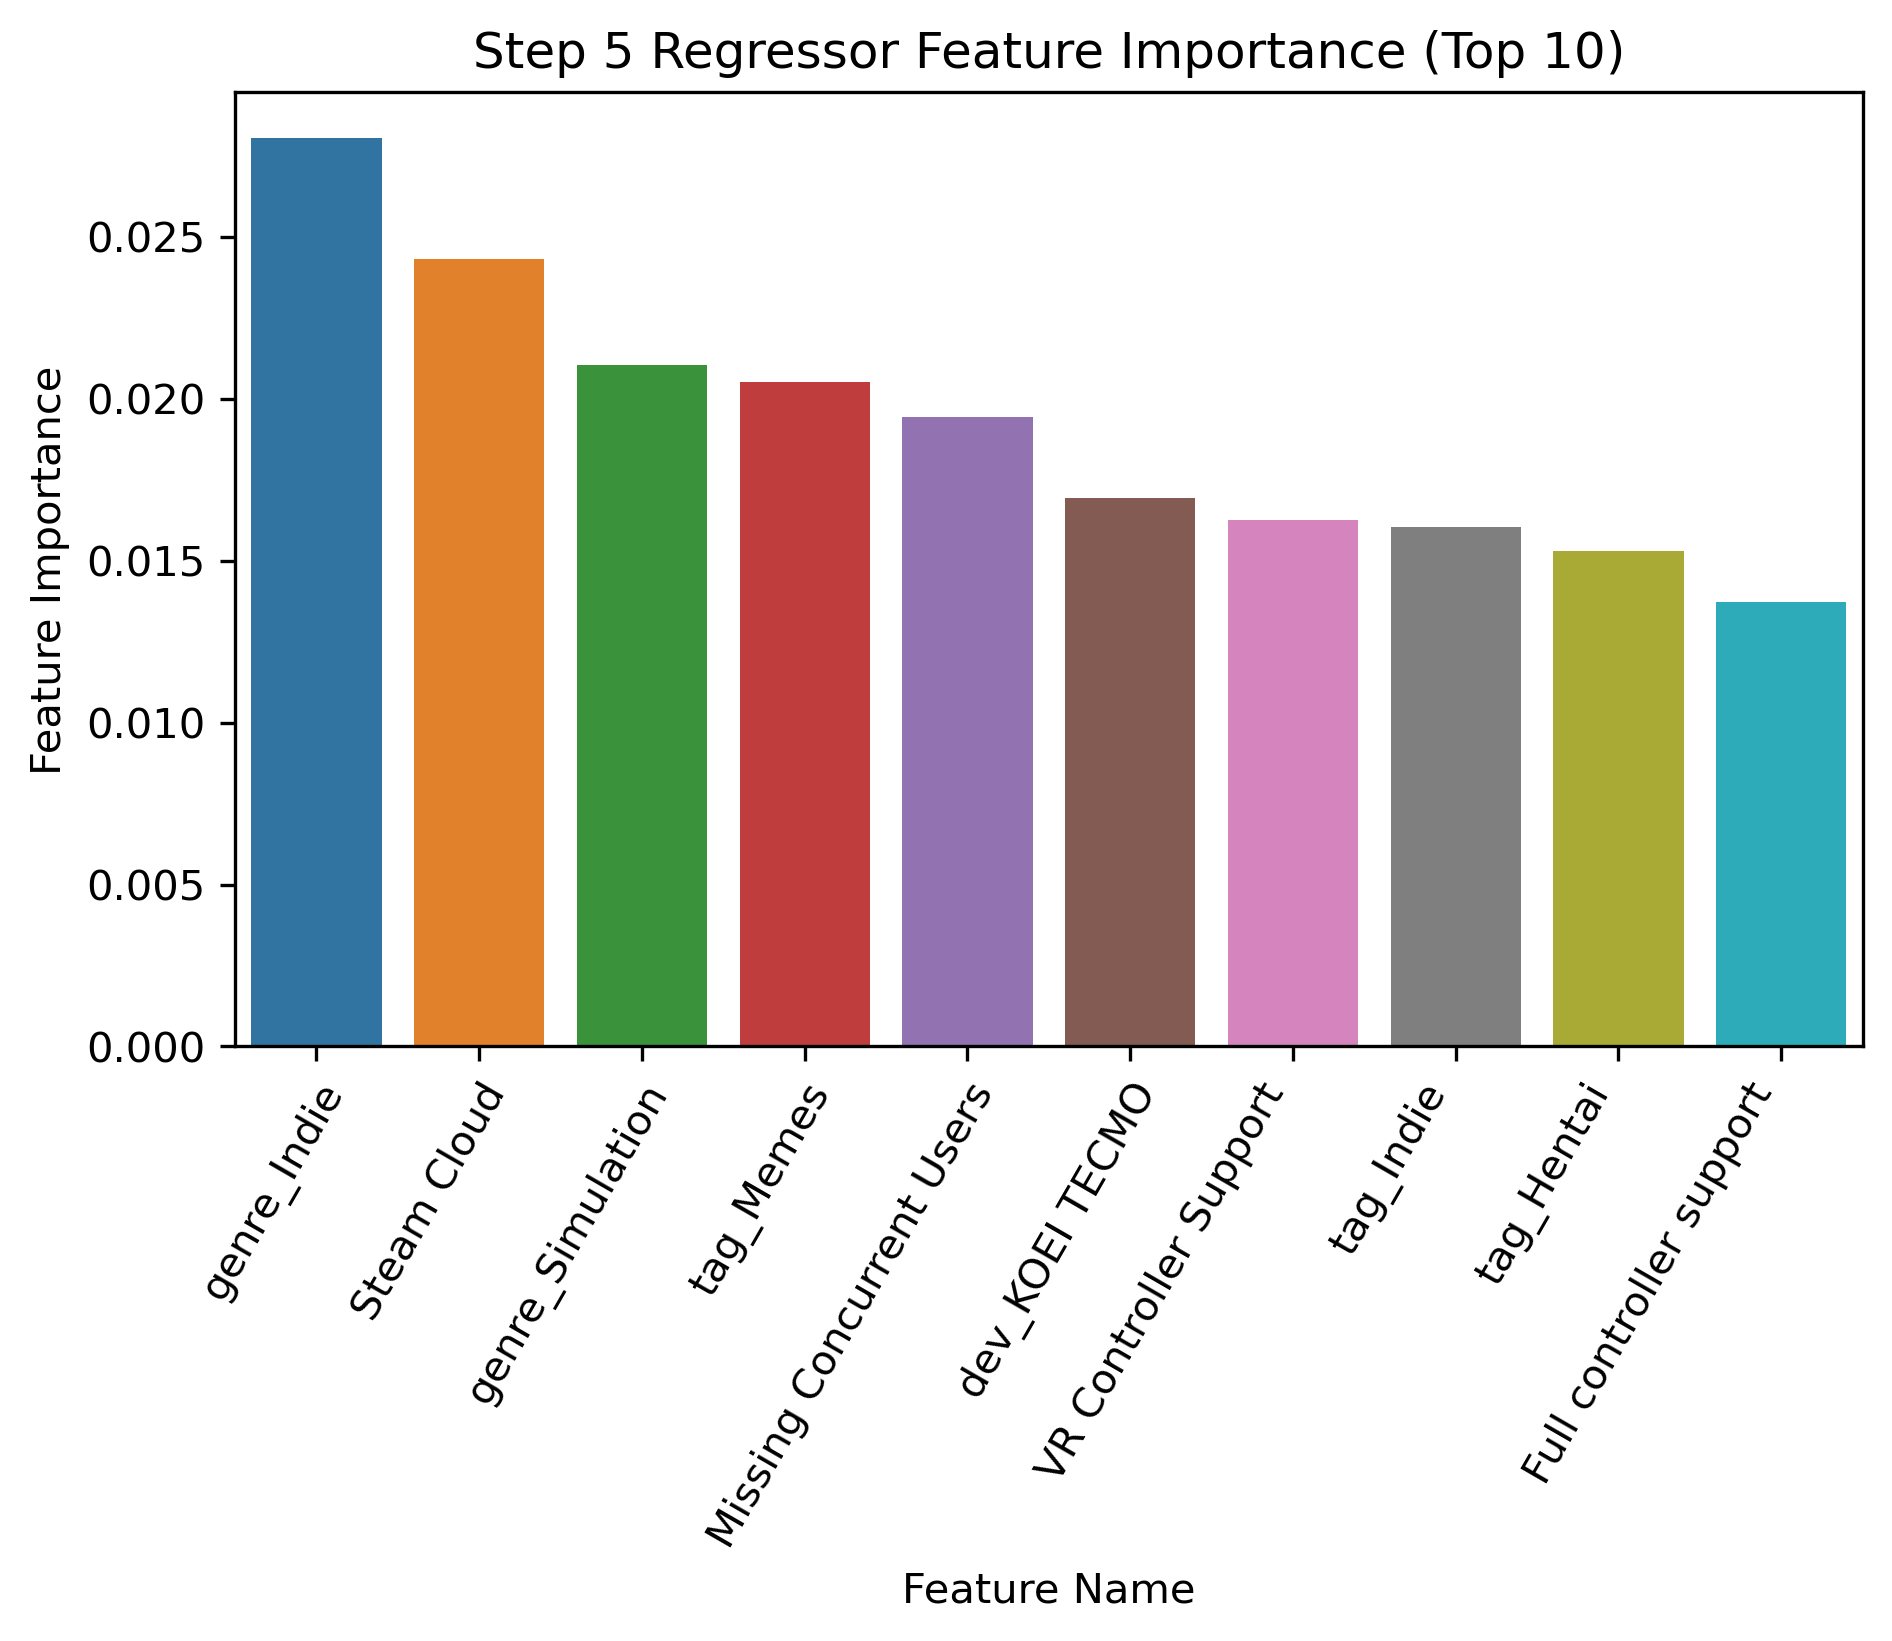

In [107]:
fig, ax = plt.subplots()
fig.set_figwidth(7)
fig.set_figheight(6)
fig.set_dpi(300)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60, rotation_mode='anchor', ha='right')
plt.subplots_adjust(bottom=.35)
bpt = sns.barplot(x="featureName", y="imp", data=nztp)
bpt.set_xlabel("Feature Name")
bpt.set_ylabel("Feature Importance")
bpt.set_title("Step 5 Regressor Feature Importance (Top 10)")
plt.savefig("S5RFI.tif", dpi=300, format="tif")

In [80]:
stp["Feature Name"] = stp["Feature Name"].str.replace("Tracked Controller Support", "VR Controller Support")

C:\Users\1king\AppData\Local\Temp\ipykernel_23456\1971990142.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stp["Feature Name"] = stp["Feature Name"].str.replace("Tracked Controller Support", "VR Controller Support")


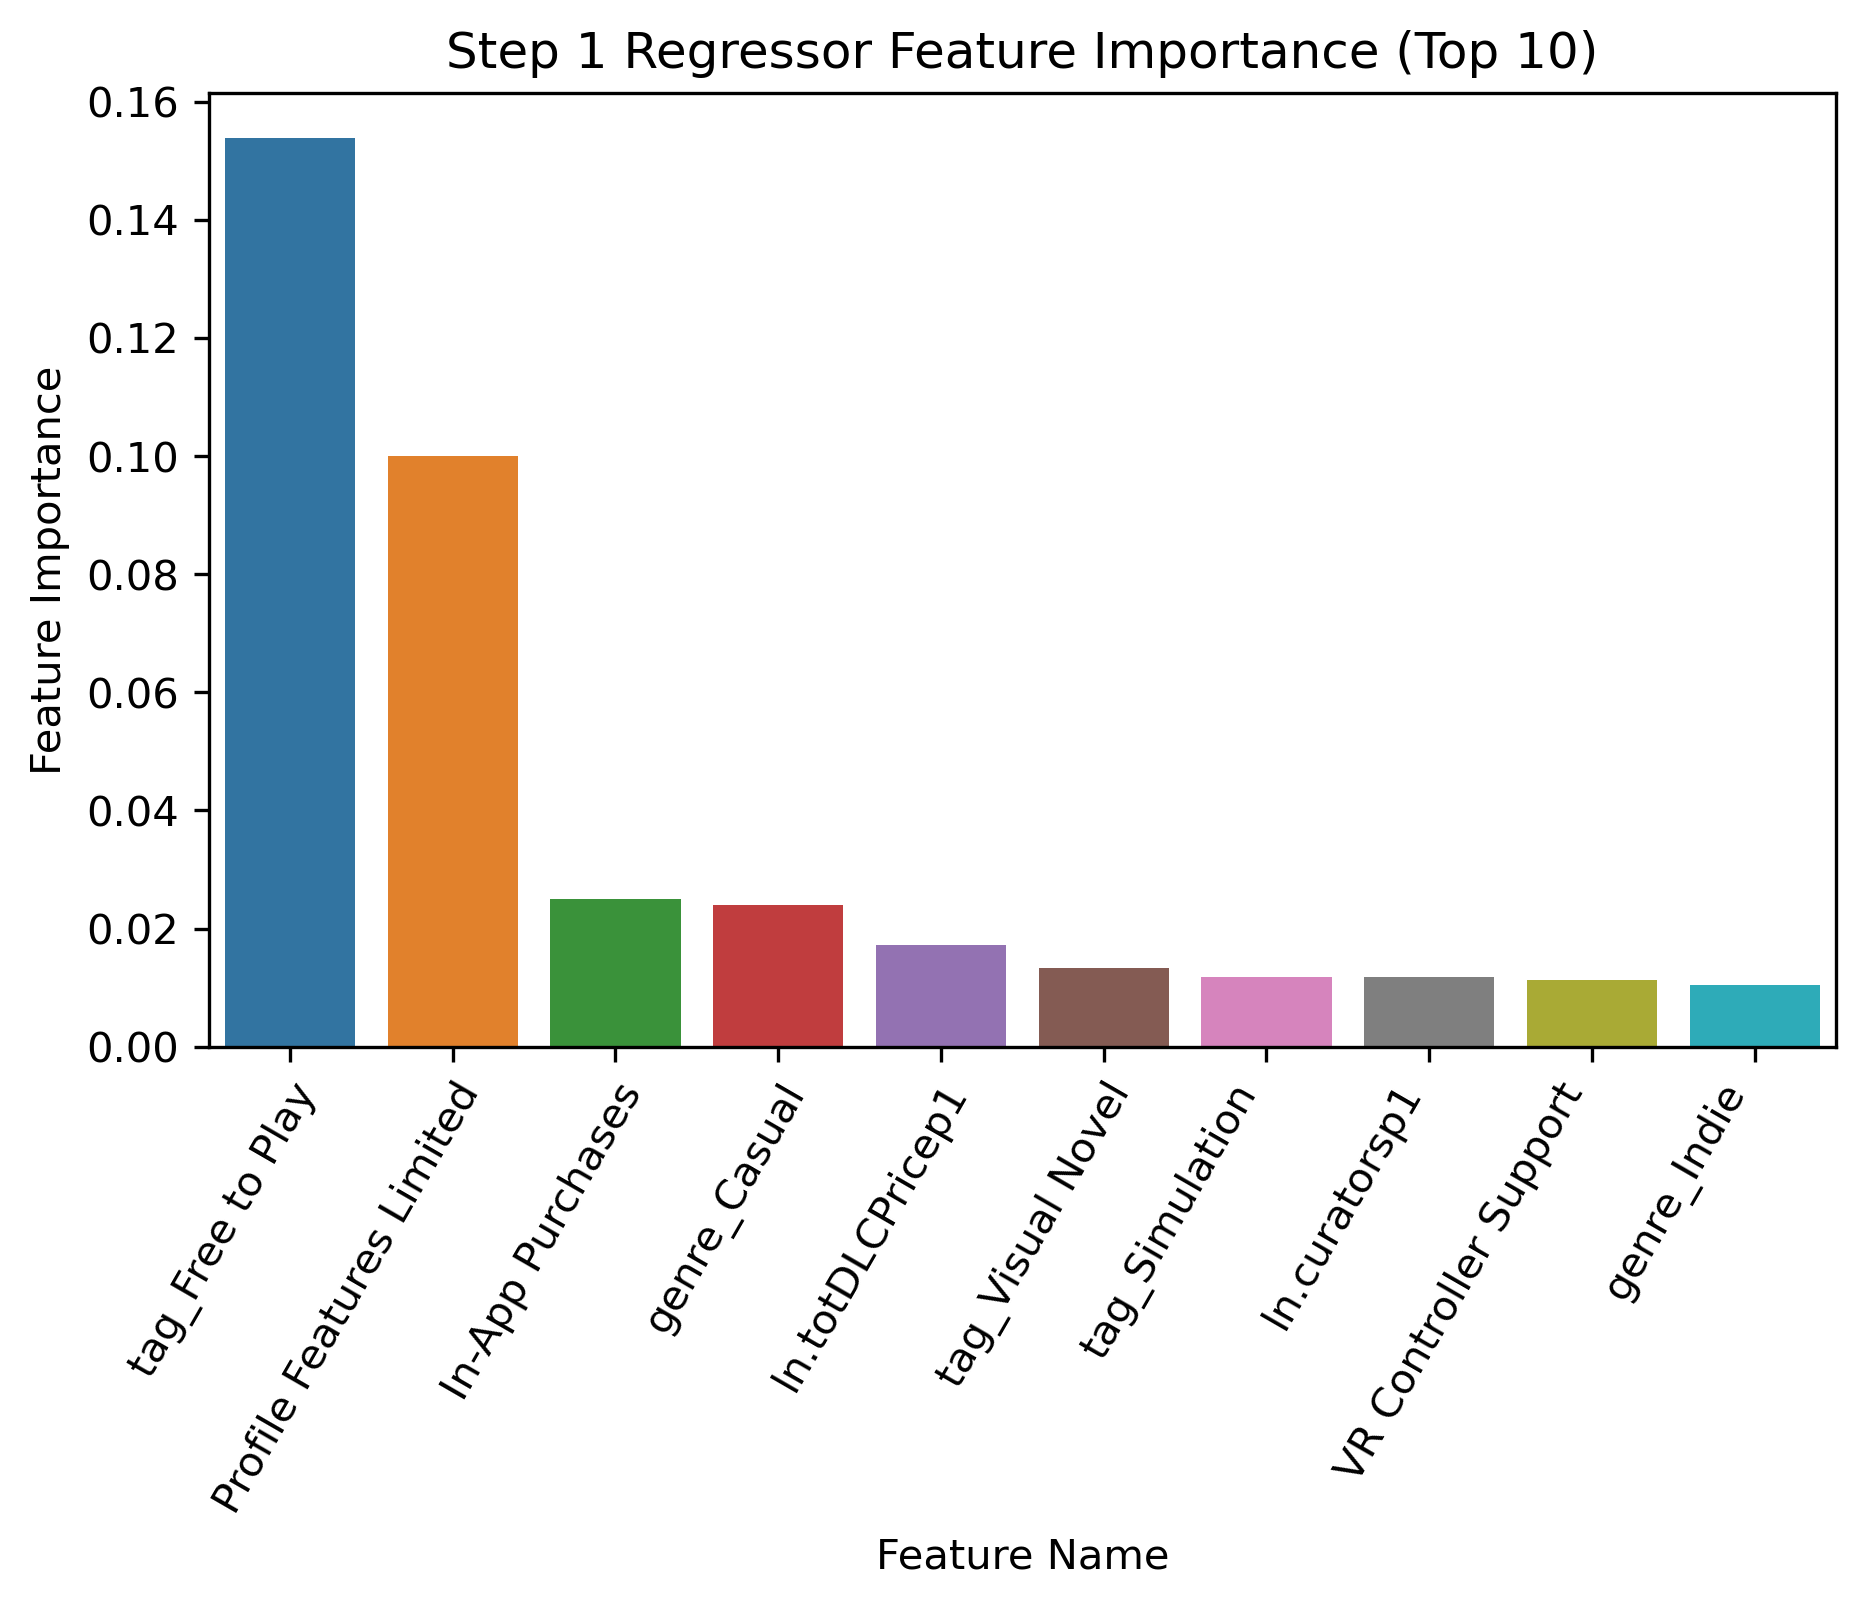

In [108]:
fig, ax = plt.subplots()
fig.set_figwidth(7)
fig.set_figheight(6)
fig.set_dpi(300)
plt.subplots_adjust(bottom=.35)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60, rotation_mode='anchor', ha='right')
bpt = sns.barplot(x="Feature Name", y="importance", data=stp)
bpt.set_xlabel("Feature Name")
bpt.set_ylabel("Feature Importance")
bpt.set_title("Step 1 Regressor Feature Importance (Top 10)")
plt.savefig("S1RFI.tif", dpi=300, format="tif")

In [224]:
a = pd.DataFrame.from_dict([{"feat": i, "importance": x} for i, x in enumerate(fin_model.feature_importances_)])

In [231]:
a = a.sort_values("importance", ascending=False)

In [233]:
a["featName"] = feature_labels(a["feat"])

In [235]:
a

,feat,importance,featName
116,116,0.153875,tag_Free to Play
68,68,0.100065,Profile Features Limited
121,121,0.025063,In-App Purchases
29,29,0.024050,genre_Casual
1566,1566,0.017264,ln.totDLCPricep1
...,...,...,...
743,743,0.000000,dev_Beamdog
741,741,0.000000,pub_Capcom
740,740,0.000000,dev_Capcom
739,739,0.000000,dev_Team17 Digital Ltd
